In [1]:
# Environment setup
import sys
from pathlib import Path

# Add src to path
workspace_root = Path.cwd()
while not (workspace_root / 'src').exists() and workspace_root != workspace_root.parent:
    workspace_root = workspace_root.parent

sys.path.insert(0, str(workspace_root / 'src'))

print(f"Project root: {workspace_root}")
print(f"Python version: {sys.version}")
print("✓ Environment configured")

Project root: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment
Python version: 3.12.0 (v3.12.0:0fb18b02c8, Oct  2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]
✓ Environment configured


In [2]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Transformers for model loading
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
import torch

# Thesis pipeline utilities
from thesis_pipeline.io.parquet import read_parquet, write_parquet

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ All imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")

✓ All imports successful
PyTorch version: 2.9.0
CUDA available: False
MPS available: True


## 1. Load Trained Stance Model from Reddit

Load the pre-trained stance detection model from Reddit notebook 16b.

In [3]:
# Paths
news_topics_dir = workspace_root / 'data' / '02_topics' / 'news'
news_stance_dir = workspace_root / 'data' / '03_stance' / 'news'
reddit_stance_dir = workspace_root / 'data' / '03_stance' / 'reddit'
news_stance_dir.mkdir(parents=True, exist_ok=True)

print(f"News topics: {news_topics_dir}")
print(f"News stance output: {news_stance_dir}")
print(f"Reddit stance model: {reddit_stance_dir}")

# Check for trained model
model_path = reddit_stance_dir / 'stance_model' / 'final_model'

if not model_path.exists():
    raise FileNotFoundError(
        f"Trained stance model not found: {model_path}\n"
        "Please run Reddit notebook 16b first to train the stance detection model."
    )

print(f"\n✓ Found trained model: {model_path}")

News topics: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/news
News stance output: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/03_stance/news
Reddit stance model: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/03_stance/reddit

✓ Found trained model: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/03_stance/reddit/stance_model/final_model


In [4]:
# Load model and tokenizer
print("Loading trained stance model...")

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"✓ Model loaded successfully")
print(f"  Device: {device}")
print(f"  Labels: {model.config.id2label}")
print(f"  Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

# Get label mapping
id2label = model.config.id2label
label2id = model.config.label2id
label_names = [id2label[i] for i in range(len(id2label))]

print(f"\n✓ Label mapping: {label_names}")

Loading trained stance model...
✓ Model loaded successfully
  Device: mps
  Labels: {0: 'pro', 1: 'against', 2: 'neutral'}
  Number of parameters: 66,955,779

✓ Label mapping: ['pro', 'against', 'neutral']


## 2. Load News Articles with Topics

Load news articles with assigned topics from notebook 23.

In [5]:
# Load news articles with topics
input_file = news_topics_dir / 'news_articles_with_topics.parquet'

if not input_file.exists():
    raise FileNotFoundError(
        f"News articles with topics not found: {input_file}\n"
        "Please run notebook 23 first to assign topics to news articles."
    )

print("Loading news articles with topics...")
df = read_parquet(input_file)

print(f"\n✓ Loaded {len(df):,} news articles")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"\nColumns: {df.columns.tolist()}")

# Show topic distribution
print(f"\nTopic distribution:")
print(df['article_topic'].value_counts())

Loading news articles with topics...

✓ Loaded 2,559 news articles

Date range: 2016-09-01 to 2016-10-31

Columns: ['date', 'title', 'plain_text', 'requested_url', 'language', 'article_topic', 'max_similarity', 'sim_climate_change', 'sim_donald_trump', 'sim_gun_control', 'sim_immigration', 'sim_vaccination']

Topic distribution:
article_topic
donald_trump      1569
gun_control        471
climate_change     222
immigration        190
vaccination        107
Name: count, dtype: int64


In [6]:
# Data overview
print("\nData overview:")
print(f"  Total articles: {len(df):,}")
print(f"  Unique topics: {df['article_topic'].nunique()}")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nText availability:")
print(f"  Title: {df['title'].notna().sum():,} ({df['title'].notna().sum()/len(df)*100:.1f}%)")
print(f"  Text: {df['plain_text'].notna().sum():,} ({df['plain_text'].notna().sum()/len(df)*100:.1f}%)")

print(f"\nText length statistics:")
print(f"  Title: {df['title'].str.len().mean():.0f} chars (mean)")
print(f"  Article: {df['plain_text'].str.len().mean():.0f} chars (mean)")


Data overview:
  Total articles: 2,559
  Unique topics: 5
  Date range: 2016-09-01 to 2016-10-31

Text availability:
  Title: 2,559 (100.0%)
  Text: 2,559 (100.0%)

Text length statistics:
  Title: 58 chars (mean)
  Article: 3033 chars (mean)


## 3. Prepare Data for Prediction

Prepare article texts for stance prediction.

In [7]:
# Prepare texts for prediction
print("Preparing article texts for stance prediction...")

# Use title + article text (similar to topic detection)
# For stance, we'll focus on the full article text
df['text_for_stance'] = (
    df['title'].fillna('') + ' ' + 
    df['plain_text'].fillna('')
)

# Check for empty texts
empty_texts = df['text_for_stance'].str.strip().eq('').sum()
if empty_texts > 0:
    print(f"\n⚠️  Warning: {empty_texts} articles have empty text")
    print("   These will still be processed but may have low confidence predictions")

print(f"\n✓ Prepared {len(df):,} article texts")
print(f"  Average length: {df['text_for_stance'].str.len().mean():.0f} characters")
print(f"  Max length: {df['text_for_stance'].str.len().max():.0f} characters")

Preparing article texts for stance prediction...

✓ Prepared 2,559 article texts
  Average length: 3092 characters
  Max length: 10019 characters


In [8]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding=False,  # Will pad dynamically in batches
        truncation=True,
        max_length=512  # Standard BERT/DistilBERT max length
    )

# Convert to Hugging Face dataset
print("Creating prediction dataset...")

prediction_texts = df['text_for_stance'].tolist()
prediction_dataset = Dataset.from_dict({'text': prediction_texts})

print(f"✓ Created dataset with {len(prediction_dataset):,} examples")

Creating prediction dataset...
✓ Created dataset with 2,559 examples


In [9]:
# Tokenize dataset
print("Tokenizing articles...")
print("This may take a few minutes...\n")

tokenized_dataset = prediction_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text'],
    desc="Tokenizing"
)

print(f"✓ Tokenized {len(tokenized_dataset):,} articles")
print(f"  Sample token counts: {[len(tokenized_dataset[i]['input_ids']) for i in range(3)]}")

Tokenizing articles...
This may take a few minutes...



Tokenizing:   0%|          | 0/2559 [00:00<?, ? examples/s]

✓ Tokenized 2,559 articles
  Sample token counts: [290, 68, 431]


## 4. Generate Stance Predictions

Apply the trained model to all news articles.

In [10]:
# Create trainer for prediction
print("Setting up prediction pipeline...")

prediction_args = TrainingArguments(
    output_dir=str(news_stance_dir / 'predictions_temp'),
    per_device_eval_batch_size=32,  # Adjust based on your GPU memory
    report_to='none',
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=prediction_args,
    tokenizer=tokenizer,
    data_collator=data_collator
)

print("✓ Prediction pipeline ready")
print(f"  Batch size: {prediction_args.per_device_eval_batch_size}")
print(f"  Device: {device}")

Setting up prediction pipeline...
✓ Prediction pipeline ready
  Batch size: 32
  Device: mps


In [11]:
# Generate predictions
print(f"\nGenerating stance predictions for {len(df):,} news articles...")
print("This may take 10-20 minutes depending on your hardware.\n")
print("Progress will be shown below:")

prediction_start = datetime.now()

# Use trainer to predict
predictions_output = trainer.predict(tokenized_dataset)
all_predictions = np.argmax(predictions_output.predictions, axis=1)
all_probabilities = torch.softmax(torch.tensor(predictions_output.predictions), dim=1).numpy()

prediction_end = datetime.now()
prediction_duration = (prediction_end - prediction_start).total_seconds()

print(f"\n✓ Predictions complete!")
print(f"  Time: {prediction_duration/60:.1f} minutes")
print(f"  Speed: {len(df) / prediction_duration:.0f} articles/second")
print(f"  Predictions shape: {all_predictions.shape}")
print(f"  Probabilities shape: {all_probabilities.shape}")


Generating stance predictions for 2,559 news articles...
This may take 10-20 minutes depending on your hardware.

Progress will be shown below:



✓ Predictions complete!
  Time: 0.6 minutes
  Speed: 68 articles/second
  Predictions shape: (2559,)
  Probabilities shape: (2559, 3)


## 5. Add Predictions to Dataframe

Add stance labels and confidence scores to the news articles.

In [12]:
# Add predictions to dataframe
print("Adding predictions to dataframe...")

# Stance labels
df['stance_label'] = [label_names[pred] for pred in all_predictions]
df['stance_label_id'] = all_predictions

# Probabilities for each class
df['stance_prob_pro'] = all_probabilities[:, label2id['pro']]
df['stance_prob_against'] = all_probabilities[:, label2id['against']]
df['stance_prob_neutral'] = all_probabilities[:, label2id['neutral']]

# Confidence (max probability)
df['stance_confidence'] = np.max(all_probabilities, axis=1)

print("✓ Added stance predictions to dataframe")
print(f"\nNew columns:")
print("  - stance_label: predicted stance (pro/against/neutral)")
print("  - stance_label_id: numeric label (0/1/2)")
print("  - stance_prob_pro: probability of 'pro' stance")
print("  - stance_prob_against: probability of 'against' stance")
print("  - stance_prob_neutral: probability of 'neutral' stance")
print("  - stance_confidence: maximum probability (confidence)")

Adding predictions to dataframe...
✓ Added stance predictions to dataframe

New columns:
  - stance_label: predicted stance (pro/against/neutral)
  - stance_label_id: numeric label (0/1/2)
  - stance_prob_pro: probability of 'pro' stance
  - stance_prob_against: probability of 'against' stance
  - stance_prob_neutral: probability of 'neutral' stance
  - stance_confidence: maximum probability (confidence)


## 6. Analyze Stance Distribution

Analyze the predicted stance distribution across topics.

In [13]:
# Overall stance distribution
print("\n" + "="*80)
print("STANCE DISTRIBUTION IN NEWS CORPUS")
print("="*80)

print(f"\nOverall stance distribution:")
stance_counts = df['stance_label'].value_counts()
print(stance_counts)
print(f"\nPercentages:")
print(df['stance_label'].value_counts(normalize=True) * 100)

# Per topic distribution
print(f"\n{'='*80}")
print("STANCE DISTRIBUTION PER TOPIC")
print(f"{'='*80}\n")

for topic_id in sorted(df['article_topic'].unique()):
    topic_data = df[df['article_topic'] == topic_id]
    print(f"{topic_id}:")
    print(f"  Total articles: {len(topic_data):,}")
    print(f"  Stance distribution:")
    for stance, count in topic_data['stance_label'].value_counts().items():
        pct = count / len(topic_data) * 100
        print(f"    {stance}: {count:,} ({pct:.1f}%)")
    print()


STANCE DISTRIBUTION IN NEWS CORPUS

Overall stance distribution:
stance_label
against    1603
pro         700
neutral     256
Name: count, dtype: int64

Percentages:
stance_label
against    62.641657
pro        27.354435
neutral    10.003908
Name: proportion, dtype: float64

STANCE DISTRIBUTION PER TOPIC

climate_change:
  Total articles: 222
  Stance distribution:
    pro: 221 (99.5%)
    against: 1 (0.5%)

donald_trump:
  Total articles: 1,569
  Stance distribution:
    against: 1,053 (67.1%)
    pro: 291 (18.5%)
    neutral: 225 (14.3%)

gun_control:
  Total articles: 471
  Stance distribution:
    against: 429 (91.1%)
    pro: 33 (7.0%)
    neutral: 9 (1.9%)

immigration:
  Total articles: 190
  Stance distribution:
    against: 93 (48.9%)
    pro: 80 (42.1%)
    neutral: 17 (8.9%)

vaccination:
  Total articles: 107
  Stance distribution:
    pro: 75 (70.1%)
    against: 27 (25.2%)
    neutral: 5 (4.7%)



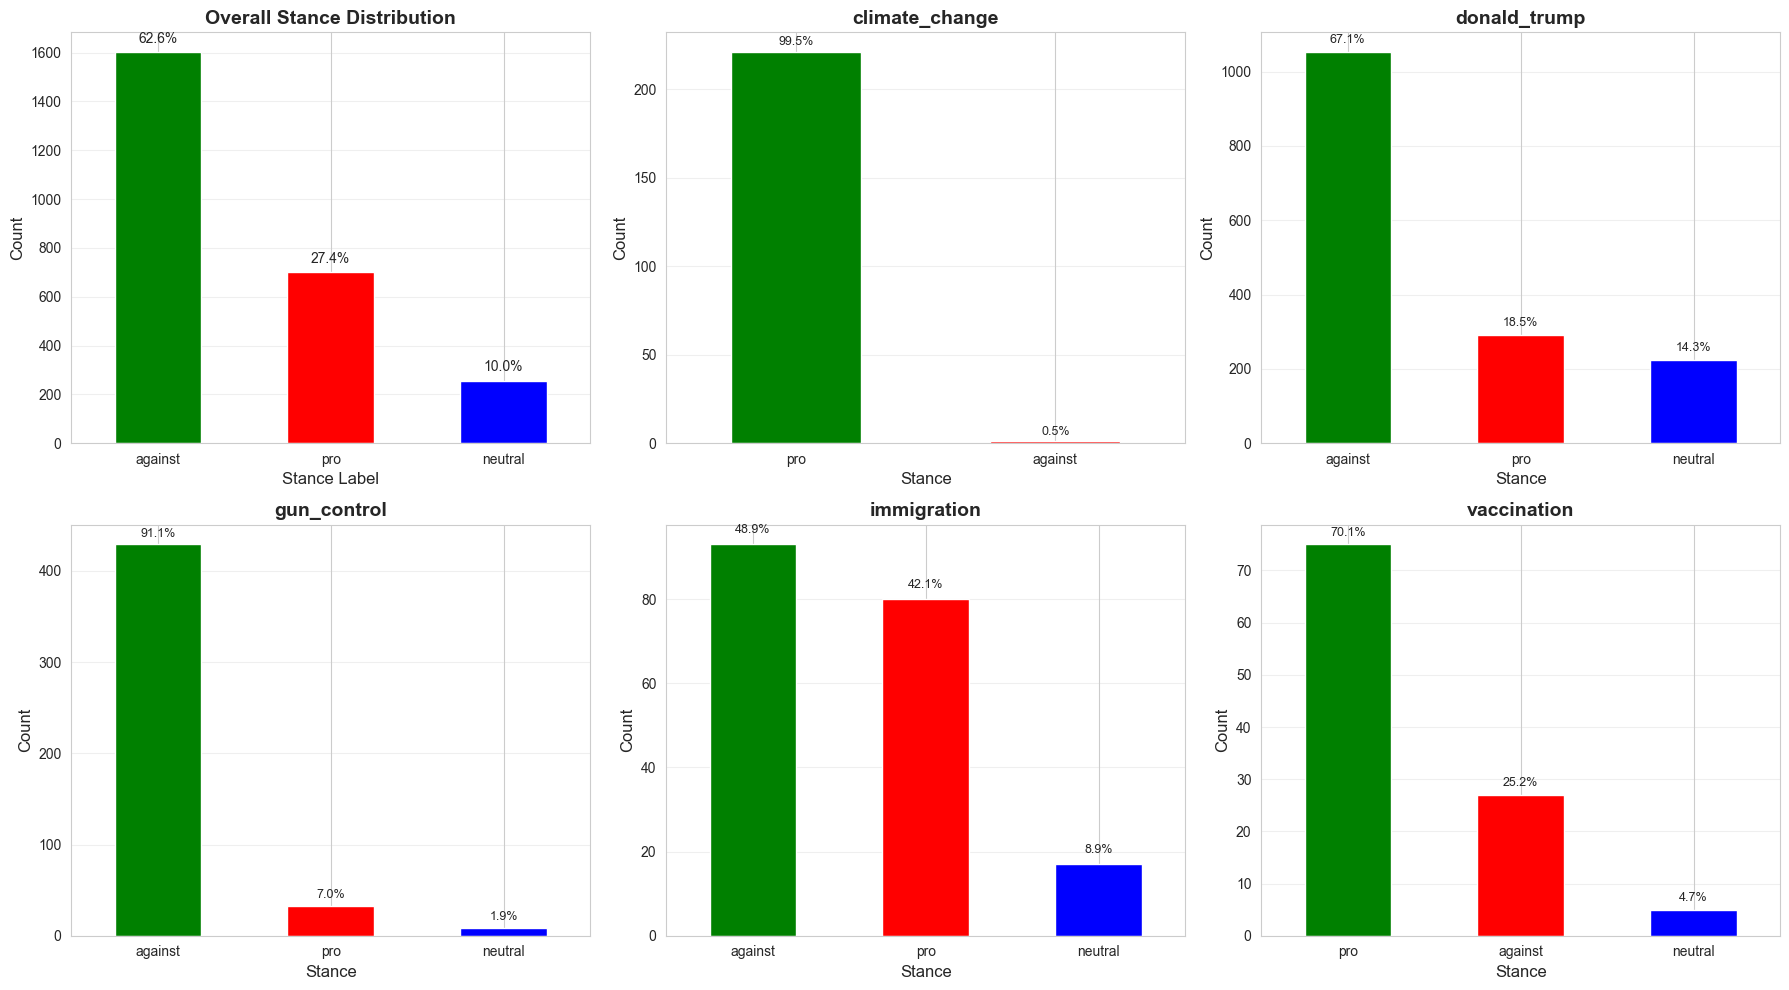

✓ Saved visualization: stance_distribution.png


In [14]:
# Visualize stance distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Overall distribution
ax = axes[0]
stance_counts.plot(kind='bar', ax=ax, color=['green', 'red', 'blue'])
ax.set_title('Overall Stance Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Stance Label', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, v in enumerate(stance_counts.values):
    pct = v / len(df) * 100
    ax.text(i, v + len(df)*0.01, f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)

# Per topic distributions
for idx, topic_id in enumerate(sorted(df['article_topic'].unique()), 1):
    ax = axes[idx]
    topic_data = df[df['article_topic'] == topic_id]
    topic_stance = topic_data['stance_label'].value_counts()
    topic_stance.plot(kind='bar', ax=ax, color=['green', 'red', 'blue'])
    ax.set_title(f'{topic_id}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Stance', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    for i, v in enumerate(topic_stance.values):
        pct = v / len(topic_data) * 100
        ax.text(i, v + len(topic_data)*0.01, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(news_stance_dir / 'stance_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved visualization: stance_distribution.png")

## 7. Confidence Analysis

Analyze prediction confidence to assess model certainty on news articles.

In [15]:
# Confidence statistics
print("\n" + "="*80)
print("CONFIDENCE ANALYSIS")
print("="*80)

print(f"\nOverall confidence statistics:")
print(df['stance_confidence'].describe())

print(f"\nConfidence by stance label:")
for stance in label_names:
    stance_data = df[df['stance_label'] == stance]
    print(f"\n{stance}:")
    print(f"  Mean: {stance_data['stance_confidence'].mean():.3f}")
    print(f"  Median: {stance_data['stance_confidence'].median():.3f}")
    print(f"  Min: {stance_data['stance_confidence'].min():.3f}")
    print(f"  Max: {stance_data['stance_confidence'].max():.3f}")

print(f"\nConfidence by topic:")
for topic_id in sorted(df['article_topic'].unique()):
    topic_data = df[df['article_topic'] == topic_id]
    print(f"\n{topic_id}:")
    print(f"  Mean: {topic_data['stance_confidence'].mean():.3f}")
    print(f"  Median: {topic_data['stance_confidence'].median():.3f}")


CONFIDENCE ANALYSIS

Overall confidence statistics:
count    2559.000000
mean        0.916967
std         0.138616
min         0.356335
25%         0.904036
50%         0.989228
75%         0.998407
max         0.999490
Name: stance_confidence, dtype: float64

Confidence by stance label:

pro:
  Mean: 0.916
  Median: 0.992
  Min: 0.356
  Max: 0.999

against:
  Mean: 0.935
  Median: 0.993
  Min: 0.370
  Max: 0.999

neutral:
  Mean: 0.805
  Median: 0.852
  Min: 0.404
  Max: 0.998

Confidence by topic:

climate_change:
  Mean: 0.992
  Median: 0.999

donald_trump:
  Mean: 0.898
  Median: 0.975

gun_control:
  Mean: 0.963
  Median: 0.999

immigration:
  Mean: 0.893
  Median: 0.982

vaccination:
  Mean: 0.885
  Median: 0.963


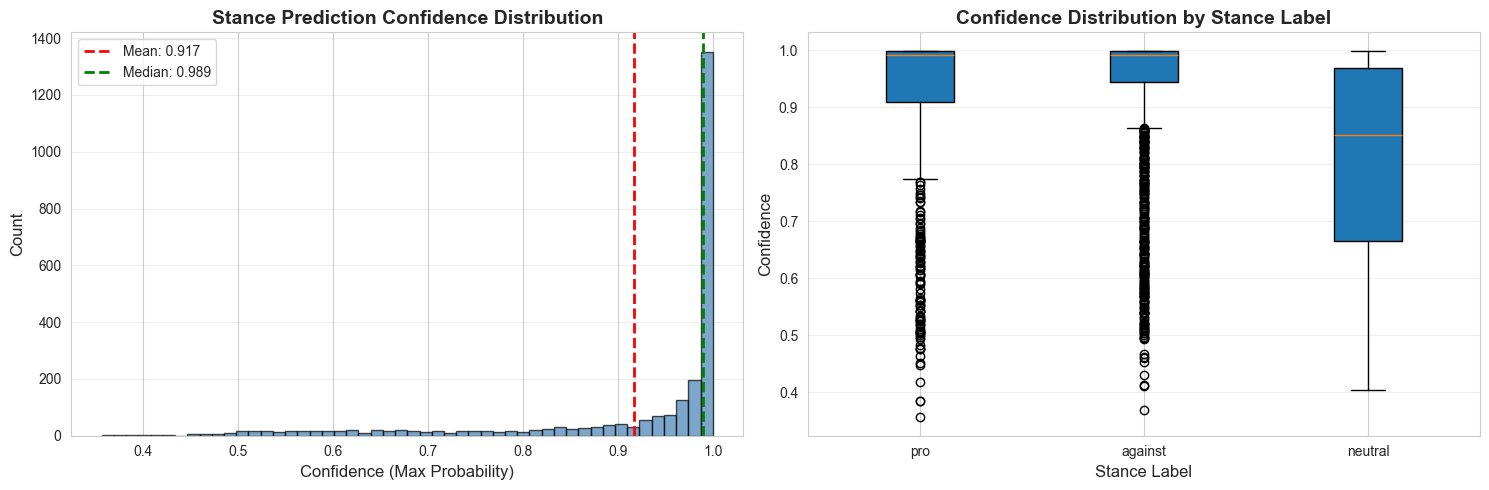

✓ Saved visualization: confidence_distribution.png


In [16]:
# Plot confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall confidence distribution
ax = axes[0]
ax.hist(df['stance_confidence'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(df['stance_confidence'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {df["stance_confidence"].mean():.3f}')
ax.axvline(df['stance_confidence'].median(), color='green', linestyle='--', linewidth=2, 
           label=f'Median: {df["stance_confidence"].median():.3f}')
ax.set_title('Stance Prediction Confidence Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Confidence (Max Probability)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Confidence by stance label
ax = axes[1]
confidence_by_stance = [df[df['stance_label'] == stance]['stance_confidence'].values 
                        for stance in label_names]
ax.boxplot(confidence_by_stance, labels=label_names, patch_artist=True)
ax.set_title('Confidence Distribution by Stance Label', fontsize=14, fontweight='bold')
ax.set_xlabel('Stance Label', fontsize=12)
ax.set_ylabel('Confidence', fontsize=12)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(news_stance_dir / 'confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved visualization: confidence_distribution.png")

In [17]:
# Identify low-confidence predictions
LOW_CONFIDENCE_THRESHOLD = 0.5

low_confidence = df[df['stance_confidence'] < LOW_CONFIDENCE_THRESHOLD]

print(f"\n⚠️  Low confidence predictions (< {LOW_CONFIDENCE_THRESHOLD}):")
print(f"  Count: {len(low_confidence):,} ({len(low_confidence)/len(df)*100:.1f}%)")

if len(low_confidence) > 0:
    print(f"\n  Distribution by stance:")
    print(low_confidence['stance_label'].value_counts())
    
    print(f"\n  Distribution by topic:")
    print(low_confidence['article_topic'].value_counts())
    
    print(f"\n  These predictions may be less reliable and could benefit from manual review.")


⚠️  Low confidence predictions (< 0.5):
  Count: 36 (1.4%)

  Distribution by stance:
stance_label
pro        13
against    12
neutral    11
Name: count, dtype: int64

  Distribution by topic:
article_topic
donald_trump    28
immigration      5
gun_control      2
vaccination      1
Name: count, dtype: int64

  These predictions may be less reliable and could benefit from manual review.


## 8. Sample Predictions

Examine sample predictions to assess quality.

In [19]:
# Show sample predictions for each topic and stance combination
print("\n" + "="*80)
print("SAMPLE PREDICTIONS")
print("="*80)

for topic_id in sorted(df['article_topic'].unique()):
    print(f"\n{'='*80}")
    print(f"TOPIC: {topic_id.upper()}")
    print(f"{'='*80}\n")
    
    topic_data = df[df['article_topic'] == topic_id]
    
    for stance in label_names:
        stance_data = topic_data[topic_data['stance_label'] == stance]
        
        if len(stance_data) > 0:
            print(f"\n{stance.upper()} ({len(stance_data):,} articles):")
            print("-" * 80)
            
            # Show 2 samples: 1 high confidence, 1 medium confidence
            samples = []
            
            # High confidence
            if len(stance_data) > 0:
                high_conf = stance_data.nlargest(1, 'stance_confidence')
                if len(high_conf) > 0:
                    samples.append(('High confidence', high_conf.iloc[0]))
            
            # Medium/threshold confidence
            medium_conf = stance_data[
                (stance_data['stance_confidence'] >= 0.45) & 
                (stance_data['stance_confidence'] <= 0.55)
            ]
            if len(medium_conf) > 0:
                samples.append(('Medium confidence', medium_conf.sample(1, random_state=42).iloc[0]))
            
            for sample_type, row in samples:
                print(f"\n  [{sample_type}] Confidence: {row['stance_confidence']:.3f}")
                print(f"  Probabilities: pro={row['stance_prob_pro']:.3f}, "
                      f"against={row['stance_prob_against']:.3f}, "
                      f"neutral={row['stance_prob_neutral']:.3f}")
                print(f"  Date: {row['date']}")
                print(f"  Title: {row['title']}")
                print(f"  Text preview: {row['plain_text']}...")
                print()
        else:
            print(f"\n{stance.upper()}: No articles predicted with this stance")


SAMPLE PREDICTIONS

TOPIC: CLIMATE_CHANGE


PRO (221 articles):
--------------------------------------------------------------------------------

  [High confidence] Confidence: 0.999
  Probabilities: pro=0.999, against=0.000, neutral=0.000
  Date: 2016-10-20
  Title: Debate moderators failed millennials
  Text preview: (CNN)In 2016, likely the hottest year on record, there's one question US presidential debate moderators had a moral obligation to ask Donald Trump and Hillary Clinton: How do you plan to address climate change and rid the economy of fossil fuels? Debate moderators completely failed millennials -- and everyone else Yet they never did.  That's just unbelievable.  We're already seeing seas rising in Miami, wildfires worsening in the West and deaths related to swollen rainstorms in Louisiana. The effects in the future, if we don't curb emissions, will be much worse, including drowned coastal cities, supercharged droughts in the Southwest, mass extinction in the natural wor

## 9. Compare with Reddit

Quick comparison with Reddit stance distribution.

Loading Reddit stance data for comparison...

✓ Loaded 86,974 Reddit comments

REDDIT VS NEWS STANCE COMPARISON

Overall stance distribution:

Reddit:
stance_label
against    59.050981
pro        22.628602
neutral    18.320418
Name: proportion, dtype: float64

News:
stance_label
against    62.641657
pro        27.354435
neutral    10.003908
Name: proportion, dtype: float64


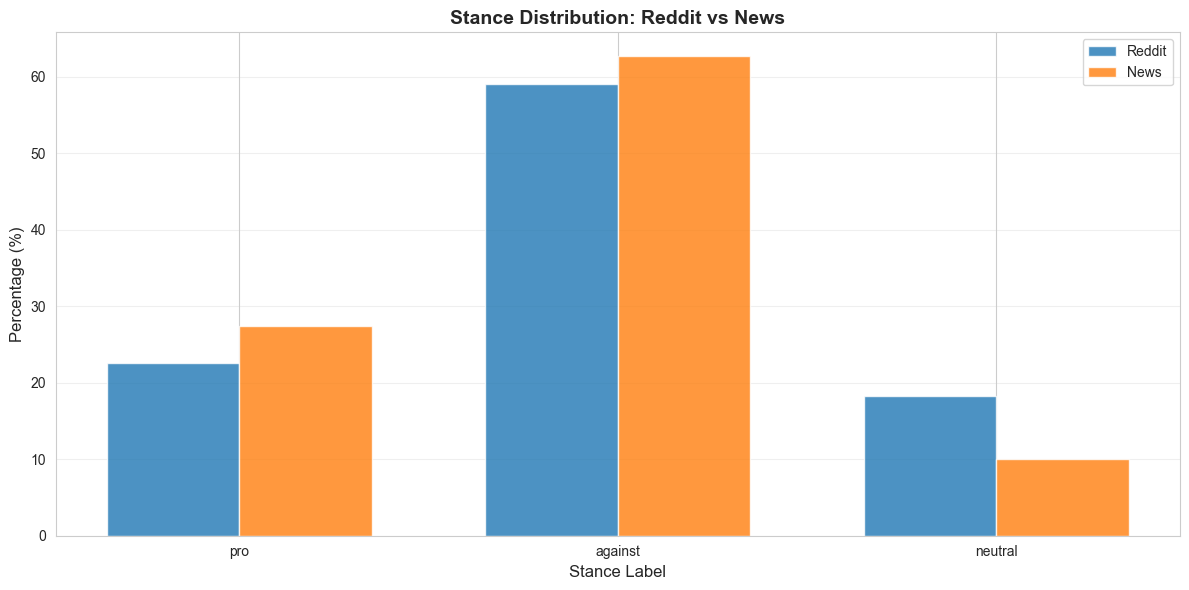


✓ Saved comparison visualization: reddit_vs_news_stance.png


In [20]:
# Load Reddit stance data for comparison
reddit_stance_file = reddit_stance_dir / 'comments_with_stance.parquet'

if reddit_stance_file.exists():
    print("Loading Reddit stance data for comparison...")
    df_reddit = read_parquet(reddit_stance_file)
    
    print(f"\n✓ Loaded {len(df_reddit):,} Reddit comments")
    
    # Compare distributions
    print("\n" + "="*80)
    print("REDDIT VS NEWS STANCE COMPARISON")
    print("="*80)
    
    print("\nOverall stance distribution:")
    print("\nReddit:")
    print(df_reddit['stance_label'].value_counts(normalize=True) * 100)
    print("\nNews:")
    print(df['stance_label'].value_counts(normalize=True) * 100)
    
    # Visualize comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    
    reddit_pct = df_reddit['stance_label'].value_counts(normalize=True) * 100
    news_pct = df['stance_label'].value_counts(normalize=True) * 100
    
    x = np.arange(len(label_names))
    width = 0.35
    
    reddit_vals = [reddit_pct.get(label, 0) for label in label_names]
    news_vals = [news_pct.get(label, 0) for label in label_names]
    
    ax.bar(x - width/2, reddit_vals, width, label='Reddit', alpha=0.8)
    ax.bar(x + width/2, news_vals, width, label='News', alpha=0.8)
    
    ax.set_xlabel('Stance Label', fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_title('Stance Distribution: Reddit vs News', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(label_names)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(news_stance_dir / 'reddit_vs_news_stance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Saved comparison visualization: reddit_vs_news_stance.png")
    
else:
    print("\n⚠️  Reddit stance data not found, skipping comparison")
    print(f"   Expected: {reddit_stance_file}")

## 10. Save Results

Save news articles with stance predictions.

In [21]:
# Select columns to save
output_columns = [
    'date', 'title', 'plain_text', 'requested_url', 'language',
    'article_topic', 'max_similarity',
    'stance_label', 'stance_label_id',
    'stance_prob_pro', 'stance_prob_against', 'stance_prob_neutral',
    'stance_confidence'
]

# Only keep columns that exist
output_columns = [col for col in output_columns if col in df.columns]

print(f"Saving {len(output_columns)} columns:")
print(f"  {output_columns}")

# Save to file
output_file = news_stance_dir / 'news_articles_with_stance.parquet'
write_parquet(df[output_columns], output_file)

print(f"\n✓ Saved: {output_file}")
print(f"  Articles: {len(df):,}")
print(f"  Size: {output_file.stat().st_size / 1024 / 1024:.1f} MB")

Saving 13 columns:
  ['date', 'title', 'plain_text', 'requested_url', 'language', 'article_topic', 'max_similarity', 'stance_label', 'stance_label_id', 'stance_prob_pro', 'stance_prob_against', 'stance_prob_neutral', 'stance_confidence']
✓ Wrote 2,559 rows to news_articles_with_stance.parquet (4.8 MB)

✓ Saved: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/03_stance/news/news_articles_with_stance.parquet
  Articles: 2,559
  Size: 4.8 MB


In [22]:
# Save summary statistics
summary = {
    'notebook': '24_news_apply_stance_model',
    'timestamp': datetime.now().isoformat(),
    'approach': 'applied Reddit trained model to news articles',
    'model_source': 'Reddit notebook 16b',
    'model_path': str(model_path),
    'data_period': {
        'start_date': str(df['date'].min()),
        'end_date': str(df['date'].max())
    },
    'total_articles': int(len(df)),
    'prediction_time': {
        'total_seconds': float(prediction_duration),
        'total_minutes': float(prediction_duration / 60),
        'articles_per_second': float(len(df) / prediction_duration)
    },
    'stance_distribution': {
        stance: int(count) 
        for stance, count in df['stance_label'].value_counts().items()
    },
    'stance_distribution_pct': {
        stance: float(count) 
        for stance, count in (df['stance_label'].value_counts(normalize=True) * 100).items()
    },
    'confidence_statistics': {
        'mean': float(df['stance_confidence'].mean()),
        'median': float(df['stance_confidence'].median()),
        'std': float(df['stance_confidence'].std()),
        'min': float(df['stance_confidence'].min()),
        'max': float(df['stance_confidence'].max()),
        'low_confidence_count': int(len(low_confidence)),
        'low_confidence_pct': float(len(low_confidence) / len(df) * 100)
    },
    'per_topic_distribution': {
        topic_id: {
            stance: int(count)
            for stance, count in df[df['article_topic'] == topic_id]['stance_label'].value_counts().items()
        }
        for topic_id in df['article_topic'].unique()
    }
}

summary_file = news_stance_dir / '24_stance_prediction_summary.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"\n✓ Saved summary: {summary_file}")


✓ Saved summary: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/03_stance/news/24_stance_prediction_summary.json


## 11. Summary

In [23]:
# Print final summary
print("\n" + "="*80)
print("NEWS STANCE PREDICTION COMPLETE")
print("="*80)

print(f"\n📊 DATA SUMMARY:")
print(f"  Total articles: {len(df):,}")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  Topics: {df['article_topic'].nunique()}")

print(f"\n🎯 STANCE DISTRIBUTION:")
for stance, count in df['stance_label'].value_counts().items():
    pct = count / len(df) * 100
    print(f"  {stance}: {count:,} ({pct:.1f}%)")

print(f"\n📈 CONFIDENCE STATISTICS:")
print(f"  Mean: {df['stance_confidence'].mean():.3f}")
print(f"  Median: {df['stance_confidence'].median():.3f}")
print(f"  Low confidence (< 0.5): {len(low_confidence):,} ({len(low_confidence)/len(df)*100:.1f}%)")

print(f"\n⚡ PERFORMANCE:")
print(f"  Prediction time: {prediction_duration/60:.1f} minutes")
print(f"  Speed: {len(df) / prediction_duration:.0f} articles/second")

print(f"\n✅ OUTPUTS CREATED:")
print(f"  • news_articles_with_stance.parquet ({len(df):,} articles)")
print(f"  • 24_stance_prediction_summary.json")
print(f"  • stance_distribution.png")
print(f"  • confidence_distribution.png")
if reddit_stance_file.exists():
    print(f"  • reddit_vs_news_stance.png")

print("\n" + "="*80)
print("METHODOLOGY")
print("="*80)
print(f"\n✓ Applied trained model from Reddit (notebook 16b)")
print(f"  - Model: DistilBERT fine-tuned on Reddit comments")
print(f"  - 3 classes: pro, against, neutral")
print(f"  - Same model enables cross-source comparison")

print("\n" + "="*80)
print("⚠️  IMPORTANT CONSIDERATIONS")
print("="*80)
print("\n🔍 DOMAIN ADAPTATION:")
print("   • Model trained on Reddit comments (informal, conversational)")
print("   • Applied to news articles (formal, journalistic)")
print("   • May affect prediction accuracy")
print("\n📊 MODEL LIMITATIONS:")
print("   • Reddit model F1 ~0.40-0.50 (exploratory quality)")
print("   • donald_trump topic particularly weak (F1 ~0.22)")
print("   • Errors in Reddit will propagate to news predictions")
print("\n✓ VALIDATION APPROACH:")
print("   • Review sample predictions above")
print("   • Check if stance assignments make sense")
print("   • Examine low-confidence predictions")
print("   • Compare with Reddit distribution for reasonableness")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)

print("\n1. REVIEW PREDICTIONS:")
print("   - Examine sample predictions in Section 8")
print("   - Check if stance labels make sense for news articles")
print("   - Identify any systematic issues")

print("\n2. CREATE NOTEBOOK 25 - POLARIZATION:")
print("   - Calculate Esteban-Ray polarization for news")
print("   - Use same methodology as Reddit (notebook 17)")
print("   - Generate daily/weekly time series")
print("   - Enable cross-source comparison")

print("\n3. CROSS-SOURCE ANALYSIS:")
print("   - Compare Reddit vs News polarization")
print("   - Analyze temporal patterns")
print("   - Identify differences between platforms")

print("\n4. FOR FINAL THESIS (if needed):")
print("   - Consider annotating news-specific dataset")
print("   - Fine-tune model for news domain")
print("   - Re-run pipeline with improved model")

print("\n" + "="*80)


NEWS STANCE PREDICTION COMPLETE

📊 DATA SUMMARY:
  Total articles: 2,559
  Date range: 2016-09-01 to 2016-10-31
  Topics: 5

🎯 STANCE DISTRIBUTION:
  against: 1,603 (62.6%)
  pro: 700 (27.4%)
  neutral: 256 (10.0%)

📈 CONFIDENCE STATISTICS:
  Mean: 0.917
  Median: 0.989
  Low confidence (< 0.5): 36 (1.4%)

⚡ PERFORMANCE:
  Prediction time: 0.6 minutes
  Speed: 68 articles/second

✅ OUTPUTS CREATED:
  • news_articles_with_stance.parquet (2,559 articles)
  • 24_stance_prediction_summary.json
  • stance_distribution.png
  • confidence_distribution.png
  • reddit_vs_news_stance.png

METHODOLOGY

✓ Applied trained model from Reddit (notebook 16b)
  - Model: DistilBERT fine-tuned on Reddit comments
  - 3 classes: pro, against, neutral
  - Same model enables cross-source comparison

⚠️  IMPORTANT CONSIDERATIONS

🔍 DOMAIN ADAPTATION:
   • Model trained on Reddit comments (informal, conversational)
   • Applied to news articles (formal, journalistic)
   • May affect prediction accuracy

📊 MODE